In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

# 데이터 경로
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/val'

# 이미지 크기 및 채널
img_size = (224, 224)
img_channel = 3

# 이미지 데이터 전처리
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    brightness_range=(0.8,1.8),
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

# ResNet50 모델 불러오기
resnet = ResNet50(input_shape=(img_size[0], img_size[1], img_channel), weights='imagenet', include_top=False) # ImageNet으로 사전 학습된 가중치를 초기 가중치로 사용

# 새로운 분류층 추가
x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(16, activation='softmax')(x) # 클래스 개수만큼 조정

model = models.Model(inputs=resnet.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 체크포인트를 저장할 경로
checkpoint_filepath = '/content/drive/MyDrive/checkpoints50/model-{epoch:03d}.h5'

# 체크포인트 콜백 설정
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=True,
    verbose=1)

# 조기 종료 콜백 설정
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=50,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[checkpoint_callback, early_stopping_callback]) # 체크포인트 인자 추가

Found 9003 images belonging to 16 classes.
Found 2568 images belonging to 16 classes.
Epoch 1/50
563/563 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.8364 
Epoch 1: saving model to /content/drive/MyDrive/checkpoints50/model-001.h5
563/563 [==============================] - 8949s 16s/step - loss: 0.5052 - accuracy: 0.8364 - val_loss: 3.0897 - val_accuracy: 0.0487
Epoch 2/50
563/563 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9751
Epoch 2: saving model to /content/drive/MyDrive/checkpoints50/model-002.h5
563/563 [==============================] - 398s 708ms/step - loss: 0.0766 - accuracy: 0.9751 - val_loss: 0.7675 - val_accuracy: 0.7936
Epoch 3/50
563/563 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9755
Epoch 3: saving model to /content/drive/MyDrive/checkpoints50/model-003.h5
563/563 [==============================] - 397s 706ms/step - loss: 0.0751 - accuracy: 0.9755 - val_loss: 2.2205 - val_accuracy: 0.4

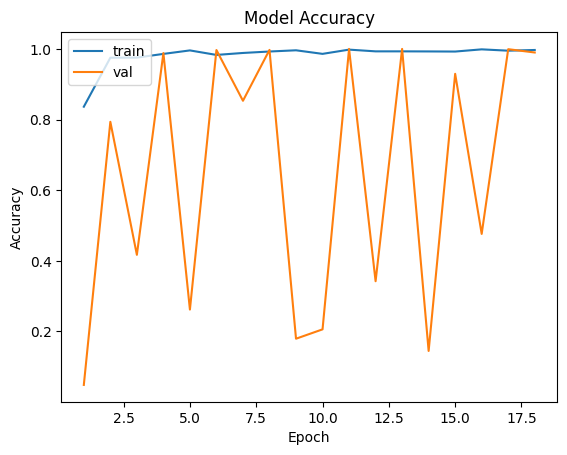

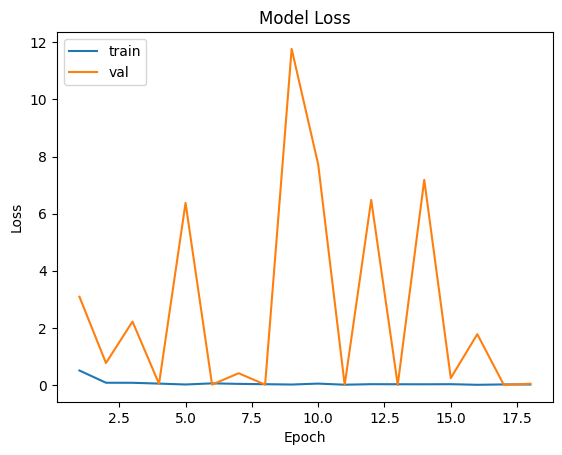

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 곡선 그리기
num_epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, num_epochs + 1)

plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 구글 드라이브에 모델 저장
model.save('/content/drive/MyDrive/ResNet50_Practice.h5')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/data2_3frame/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet50_Practice.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.2f}'.format(accuracy))
print('정밀도 : {:.2f}'.format(precision))
print('재현율 : {:.2f}'.format(recall))
print('F1-score : {:.2f}'.format(f1score))

Found 349 images belonging to 16 classes.
349/349 [==============================] - 181s 518ms/step
테스트 결과
---------------------
back_left/back_left0.jpg : back_left
back_left/back_left100.jpg : back_left
back_left/back_left107.jpg : back_left
back_left/back_left128.jpg : back_left
back_left/back_left138.jpg : back_left
back_left/back_left146.jpg : back_left
back_left/back_left16.jpg : back_left
back_left/back_left162.jpg : back_left
back_left/back_left165.jpg : back_left
back_left/back_left170.jpg : back_left
back_left/back_left18.jpg : back_left
back_left/back_left180.jpg : back_left
back_left/back_left195.jpg : back_left
back_left/back_left200.jpg : back_left
back_left/back_left50.jpg : back_left
back_left/back_left54.jpg : back_left
back_left/back_left74.jpg : back_left
back_left/back_left83.jpg : back_left
back_left/back_left92.jpg : back_left
back_left/back_left94.jpg : back_left
back_left/back_left97.jpg : back_left
back_left_hurray/back_left_hurray102.jpg : front
back_left_hur

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
